In [1]:
%load_ext autoreload
%autoreload 3 --print

In [13]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph, util as model_util
from kpsn import fitting
from kpsn.fitting import em
from kpsn.io import alignment, features
from kpsn.io.armature import Armature
from kpsn.fitting import methods
from kpsn.fitting import scans
import os, sys, shutil
from pprint import pprint
from kpsn import viz
from kpsn.viz import styles
import matplotlib.pyplot as plt
plotter, colors = styles.init_nb("vscode_dark")

import logging
logging.getLogger().setLevel(logging.INFO)

In [3]:
project_dir = '../projects/21-04-30_mo-ontogeny'
project = Project(project_dir)

# if os.path.exists(project_dir): shutil.rmtree(project_dir)
if not os.path.exists(project_dir):
    loaders.raw_npy.setup_project_config(
        project,
        filepaths = {
            '12wk_m3': '../../../data_explore/data/11_01_22_12wk_m3.npy',
            '5wk_m6': '../../../data_explore/data/10_24_22_5wk_m6.npy'},
        ref_session = '12wk_m3',
        keypoint_names = [
            'shldr', 'back', 'hips', 't_base','t_tip', 'head',
            'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
            'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
        keypoint_parents = [
            'back', 'hips', None, 'hips', 'shldr',
            'head', 'head', 'head', 'hips', 'lr_knee',
            'hips', 'rr_knee', 'shldr', 'shldr'],
        exclude_keypoints = ['t_tip'],
        subsample = 10)
    
    setup.setup_base_model_config(project)

In [35]:
cfg = config.load_project_config(project.main_config())
dataset = loaders.raw_npy.load(cfg['dataset'])

dataset, cfg = loaders.raw_npy.default_alignment.calibrate(
    project, dataset, cfg, origin = 'hips', anterior = 'head')

cfg = loaders.raw_npy.default_features.calibrate(
    project, dataset, cfg)
dataset, reduction_inverse = loaders.raw_npy.default_features._reduce(
    dataset, cfg['features'])
config.save_config(project.main_config(), cfg)

cfg = config.load_model_config(project.base_model_config())
cfg = pose.gmm.calibrate_base_model(project, dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(project, dataset, cfg)
cfg = em.calibrate_base_model(project, dataset, cfg)
config.save_model_config(project.base_model_config(), cfg)

Reloading 'kpsn.models.pose.gmm'.


INFO:root:Fitting GMM to 3592 frames
INFO:root:Fitting GMM to 3592 frames
INFO:root:Fitting GMM to 3592 frames
INFO:root:Fitting GMM to 3592 frames


### Dataset / calibration plots

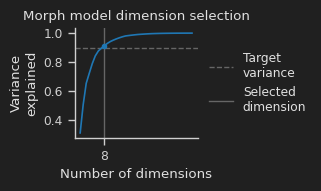

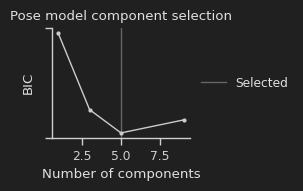

In [5]:
cfg = config.load_model_config(project.base_model_config())
calibration_plots = viz.model.plot_calibration(project, cfg)

plotter.finalize(calibration_plots["morph"], None, display = False)
plotter.finalize(calibration_plots["pose"], None, display = False)
plt.show()

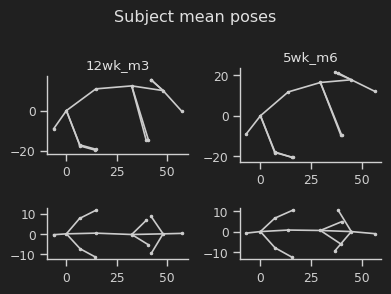

In [6]:
cfg = config.load_project_config(project.main_config())
fig = viz.general.session_means(cfg)
plotter.finalize(fig, None)

### Single model fitting

In [40]:
model_dir, cfg = create_model(project, 'first_run', {
    'fit.n_steps': 10
})

In [ ]:
model = instantiation.get_model(cfg)
params = joint.initialize_joint_model(model, dataset, cfg)

In [ ]:
model = instantiation.get_model(cfg)
cfg['fit']['mstep']['n_steps'] = 40
fit_params, fit_hist = em.iterate_em(
    model, params, dataset, cfg['fit'], log_every = 1
)

In [ ]:
fit_data = methods.fit(
    project.model('first_run'),
    log_every = 1,)

### Scan

In [36]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "prior-scan", {
    'morph.upd_var_ofs': [1e-1, 1e0, 1e1],
    'morph.upd_var_modes': [1e-2, 1e-1, 1e2],
}, model_overrides={
    'fit.learning_rate': 8,
    'fit.n_steps': 100,
    # 'pose.wish_var': 10,
    # 'pose.wish_dof': 50,
})

In [20]:
scans.run_scan(project, "prior-scan", log_every=1)

Reloading 'kpsn.fitting.methods'.


INFO:root:Continuing from checkpoint at step 49.
INFO:root:Adjusting learning rate:8 -> 0.0011134307585247043
INFO:root:Loading LR schedule: const
INFO:root:Step 50 : loss = 592336.1875
INFO:root:Step 51 : loss = 592326.0
INFO:root:Step 52 : loss = 592317.75
INFO:root:Step 53 : loss = 592306.375
INFO:root:Step 54 : loss = 592300.75
INFO:root:Step 55 : loss = 592276.25
INFO:root:Step 56 : loss = 592259.25
INFO:root:Step 57 : loss = 592232.9375
INFO:root:Step 58 : loss = 592218.5625
INFO:root:Step 59 : loss = 592204.5
INFO:root:Step 60 : loss = 592184.9375
INFO:root:Step 61 : loss = 592167.1875
INFO:root:Step 62 : loss = 592144.9375
INFO:root:Step 63 : loss = 592111.3125
INFO:root:Step 64 : loss = 592095.0625
INFO:root:Step 65 : loss = 592086.5
INFO:root:Step 66 : loss = 592077.1875
INFO:root:Step 67 : loss = 592073.0625
INFO:root:Step 68 : loss = 592061.1875
INFO:root:Step 69 : loss = 592044.5
INFO:root:Step 70 : loss = 592023.625
INFO:root:Step 71 : loss = 591999.625
INFO:root:Step 72 

##### convergence checks

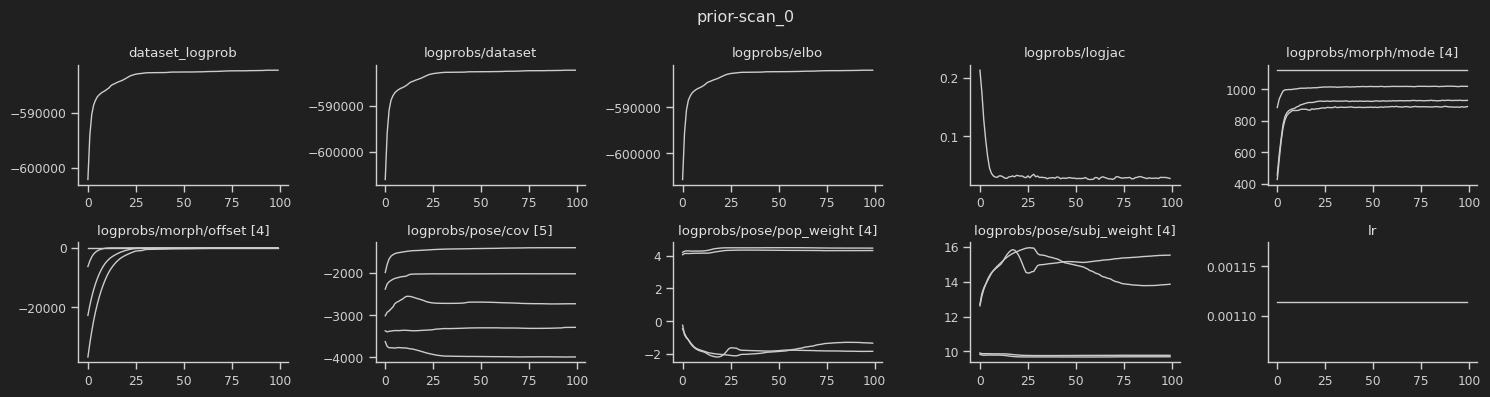

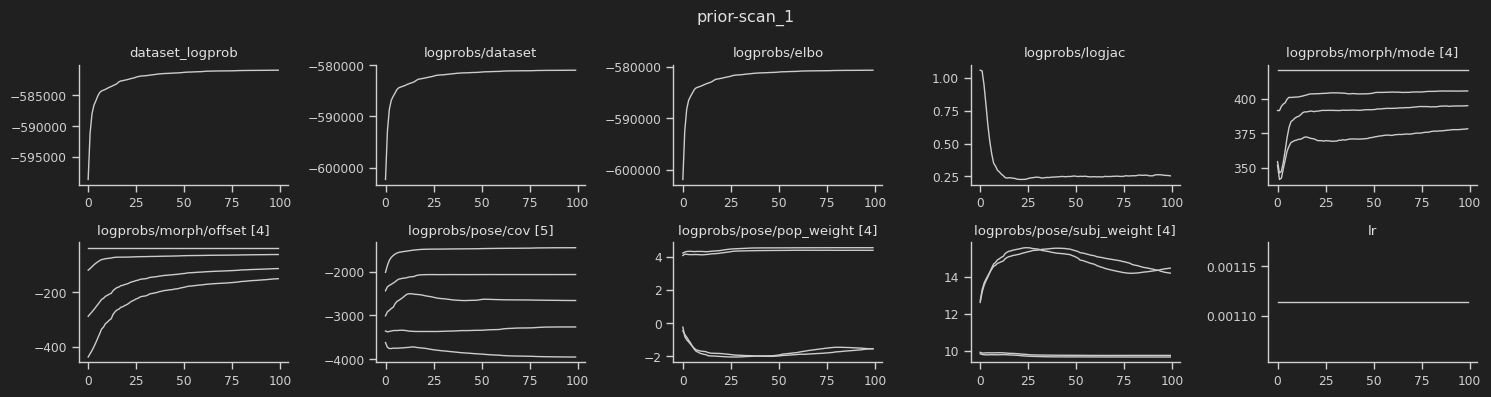

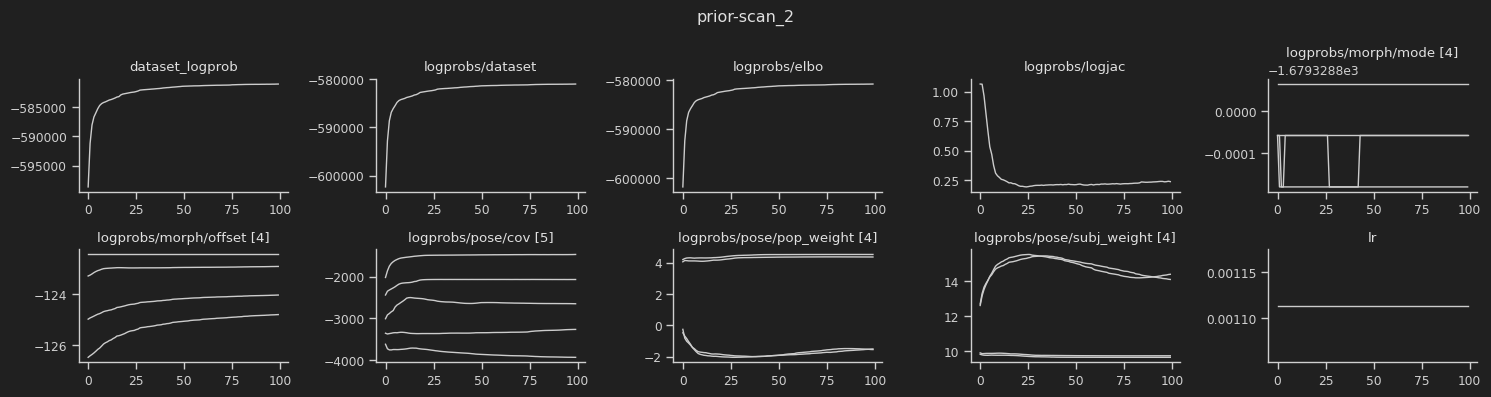

In [21]:
scan_cfg = config.load_project_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg["models"]:
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.report_plots(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

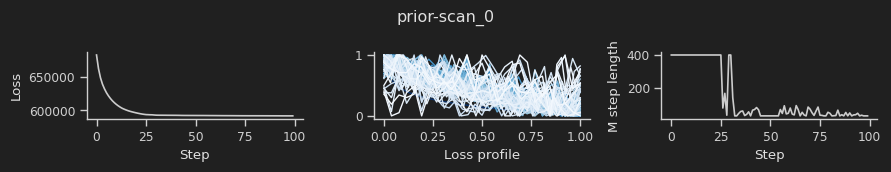

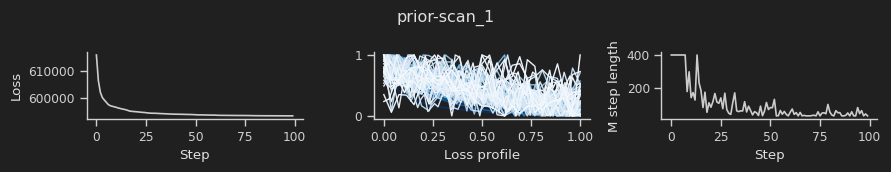

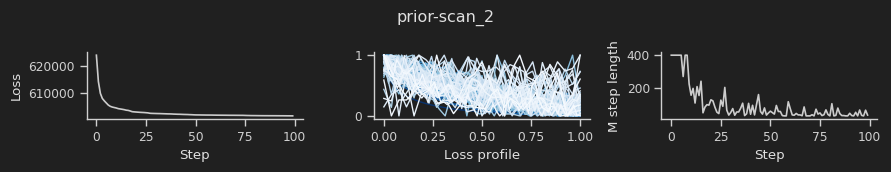

In [22]:
scan_cfg = config.load_project_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg["models"]:
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

Reloading 'kpsn.viz.model'.


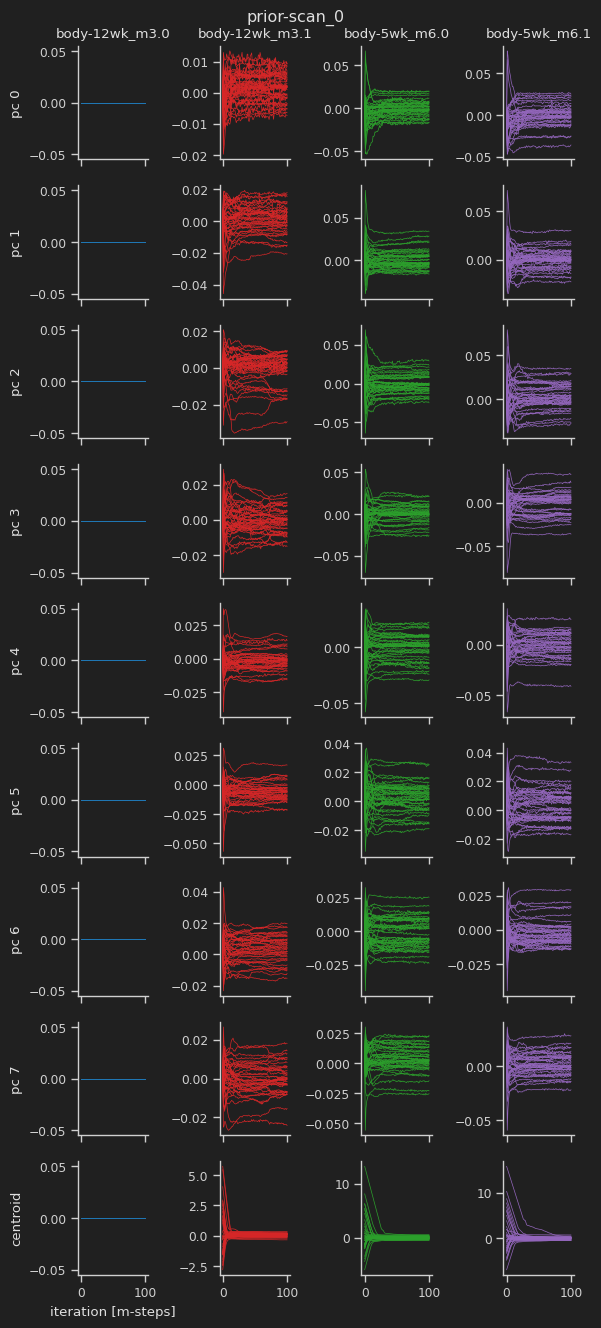

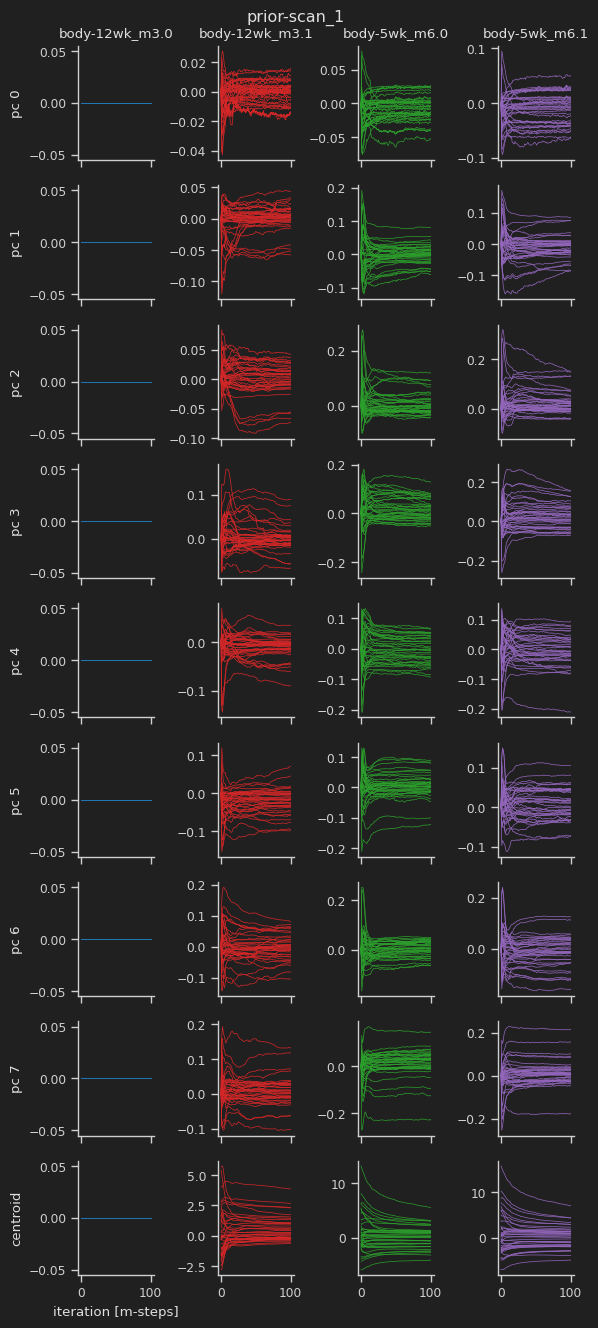

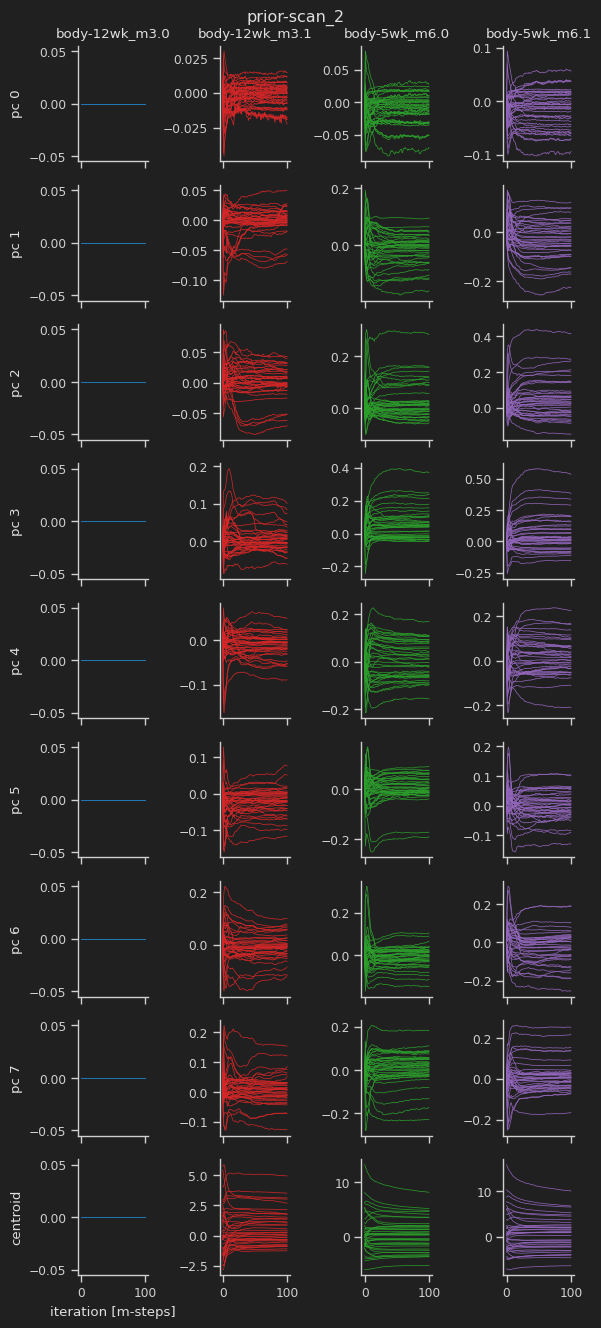

In [25]:
scan_cfg = config.load_project_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg["models"]:
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz.model.lra_param_convergence(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

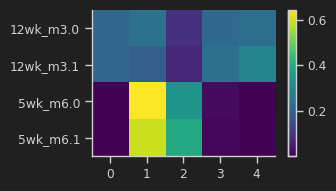

bidict({0: '12wk_m3.0', 1: '12wk_m3.1', 2: '5wk_m6.0', 3: '5wk_m6.1'})


In [34]:
model_name = 'prior-scan_2'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
_dataset = loaders.load_dataset(cfg["dataset"])
_dataset = methods.modify_dataset(project.model(model_name), _dataset)
fig, ax = plt.subplots(figsize = (3.5, 2))
plt.imshow(ckpt["params"].pose.subj_weights)
ax.set_yticks(range(len(_dataset.sessions)))
ax.set_yticklabels([_dataset._session_names[i] for i in range(len(_dataset.sessions))])
plt.colorbar()
plotter.finalize(fig, None)
print(_dataset._session_names)

##### scan plots

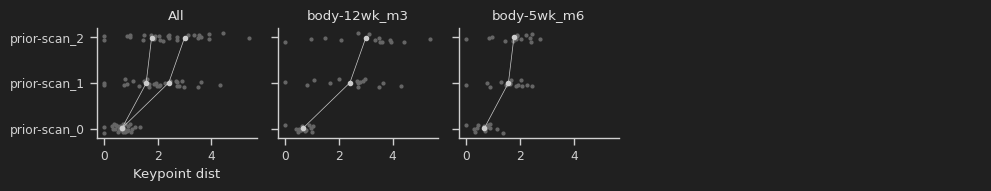

In [27]:
fig = viz.scans.withinbody_reconst_errs(project, "prior-scan")
plotter.finalize(fig, None)

Reloading 'kpsn.viz.scans'.


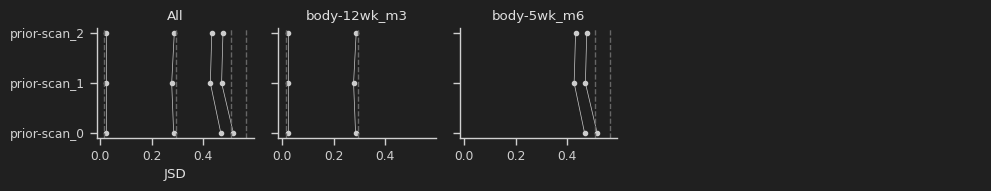

In [13]:
fig = viz.scans.jsds_to_reference(project, "prior-scan")
plotter.finalize(fig, None)

### GMM calibration

In [30]:
cfg = config.load_model_config(project.base_model_config())
model = instantiation.get_model(cfg)

dataset = loaders.raw_npy.load(cfg["dataset"])
dataset_aligned, align_inverse = alignment.align(dataset, cfg["alignment"])
dataset_reduced, reduction_inverse = features.reduce_to_features(
    dataset_aligned, cfg["features"]
)

# cfg = pose.gmm.calibrate_base_model(project, dataset, cfg)


In [32]:
import jax.random as jr
from sklearn import mixture

cfg_ = cfg['pose']
init_pts = dataset_reduced.get_session(dataset.ref_session)
init_cfg = cfg_["init"]

subsampe_amt = 2000
if subsampe_amt is not False:
    if subsampe_amt < 1:
        n_frames = int(len(init_pts) * subsampe_amt)
    else:
        n_frames = subsampe_amt
    init_pts = jr.choice(
        jr.PRNGKey(init_cfg["seed"]), init_pts, (n_frames,), replace=False
    )

component_checks = [1, 5, 7, 10, 15]
mixtures = []
for n_components in component_checks:
    logging.info(f"Fitting GMM with {n_components} components to {init_pts.shape[0]} frames")
    init_mix = mixture.GaussianMixture(
        n_components=n_components,
        random_state=init_cfg["seed"] + n_components,
    )
    init_mix.fit(init_pts)
    mixtures.append(init_mix)

INFO:root:Fitting GMM with 1 components to 2000 frames
INFO:root:Fitting GMM with 5 components to 2000 frames
INFO:root:Fitting GMM with 7 components to 2000 frames
INFO:root:Fitting GMM with 10 components to 2000 frames
INFO:root:Fitting GMM with 15 components to 2000 frames


In [33]:
aics = [m.aic(init_pts) for m in mixtures]
bics = [m.bic(init_pts) for m in mixtures]

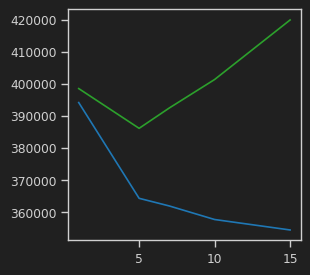

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (3, 3))
ax.plot(component_checks, aics, colors.C[0], label="AIC")
ax.plot(component_checks, bics, colors.C[1], label="AIC")

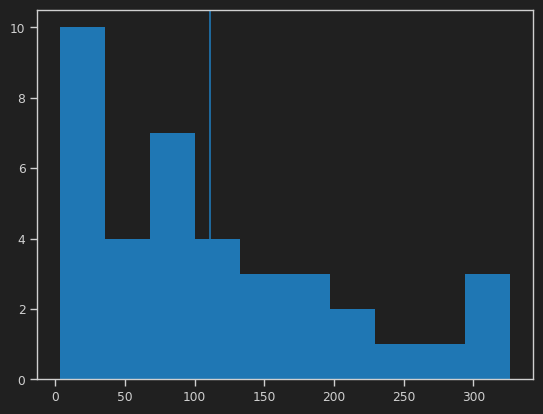

In [12]:
import jax.numpy as jnp
init_pts = dataset_reduced.get_session(dataset.ref_session)
vars = jnp.var(init_pts, axis=0)

import matplotlib.pyplot as plt
plt.hist(vars)
plt.axvline(vars.mean())

Somewhere else we might examine the correspondence between this BIC trough and scan curves.

### LRA calibration

In [27]:
cfg = config.load_model_config(project.base_model_config())
model = instantiation.get_model(cfg)

dataset = loaders.raw_npy.load(cfg["dataset"])
dataset_aligned, align_inverse = alignment.align(dataset, cfg["alignment"])
dataset_reduced, reduction_inverse = features.reduce_to_features(
    dataset_aligned, cfg["features"]
)

In [34]:
from kpsn.pca import fit_with_center
import jax.numpy as jnp
init_pts = dataset_reduced.get_session(cfg_["ref_session"])
pcs = fit_with_center(init_pts)


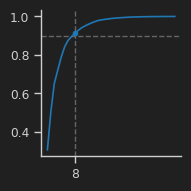

In [53]:
fig, ax = plt.subplots(figsize = (2, 2))
scree = jnp.cumsum(pcs._pcadata.variances()) / pcs._pcadata.variances().sum()
selected_ix = jnp.argmax(scree > 0.9)
ax.axhline(0.9, color = colors.subtle, linestyle = '--', lw = 1)
ax.axvline(selected_ix, color = colors.subtle, linestyle = '--', lw = 1)
ax.plot(scree, color = colors.C[0])
ax.plot([selected_ix], [scree[selected_ix]], 'o', color = colors.C[0], ms = 3)
ax.set_xticks([selected_ix])
ax.set_xticklabels([selected_ix])
plotter.finalize(fig, None)

### Model iteration

##### Plots

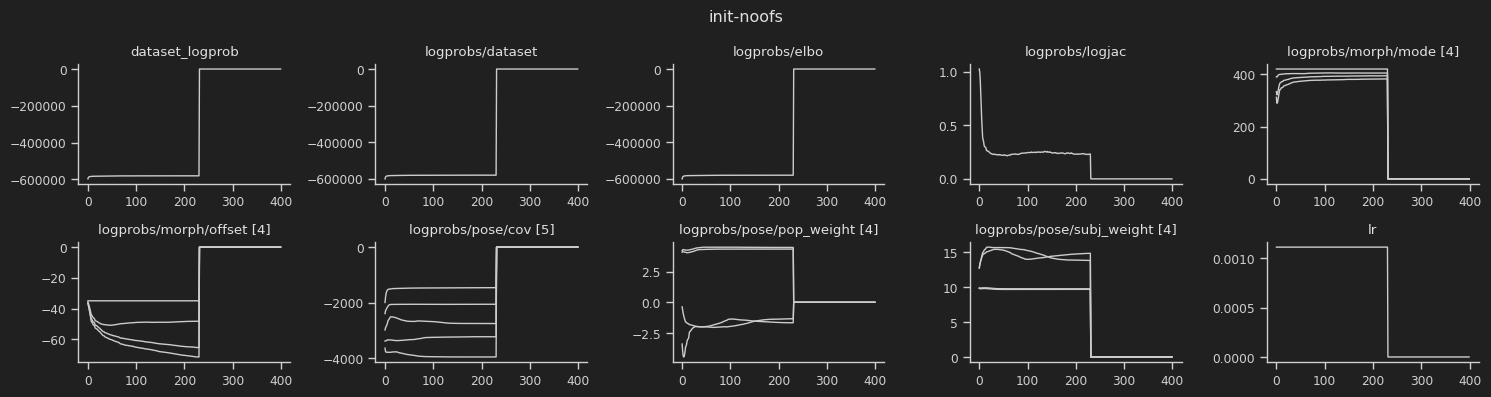

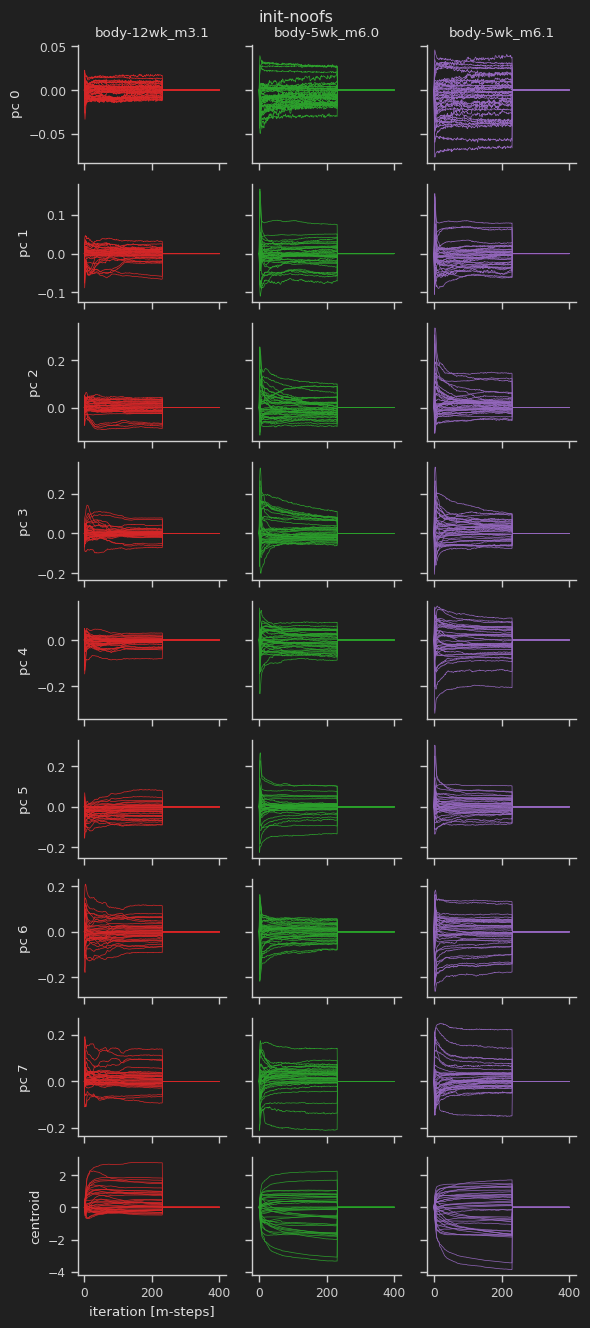

In [10]:
model_name = 'init-noofs'
ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.report_plots(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None)

ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.lra_param_convergence(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None)

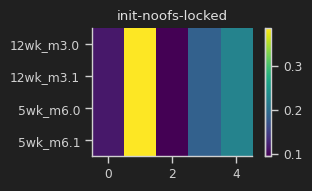

bidict({0: '12wk_m3.0', 1: '12wk_m3.1', 2: '5wk_m6.0', 3: '5wk_m6.1'})


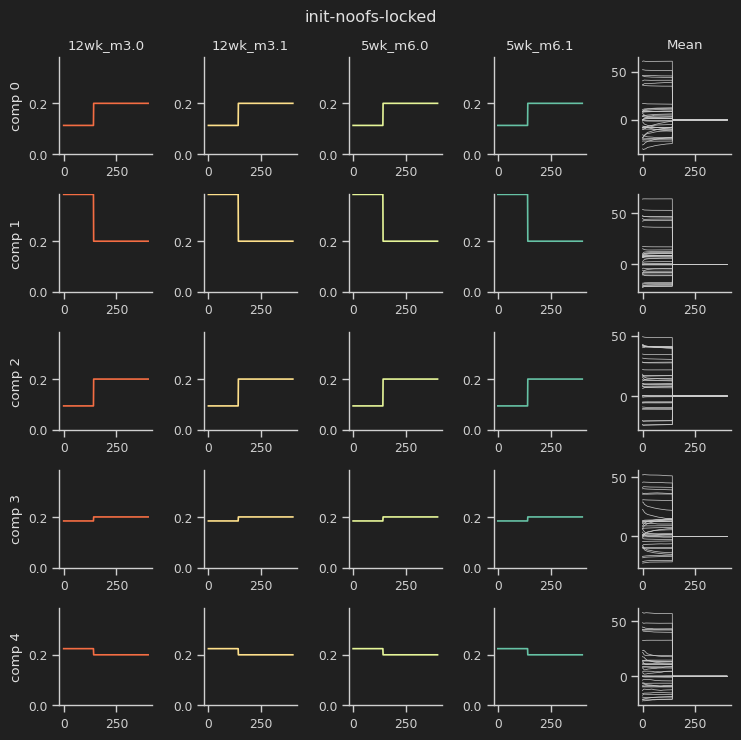

In [7]:
model_name = 'init-noofs-locked'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
_dataset = loaders.load_dataset(cfg["dataset"])
_dataset = methods.modify_dataset(project.model(model_name), _dataset)
fig, ax = plt.subplots(figsize = (3.5, 2))
plt.imshow(ckpt["params"].pose.subj_weights)
ax.set_yticks(range(len(_dataset.sessions)))
ax.set_yticklabels([_dataset._session_names[i] for i in range(len(_dataset.sessions))])
ax.set_title(model_name)
plt.colorbar()
plotter.finalize(fig, None)
print(_dataset._session_names)

ckpt = methods.load_fit(project.model(model_name))
fig = viz.model.gmm_param_convergence(ckpt)
fig.suptitle(model_name)
plotter.finalize(fig, None)

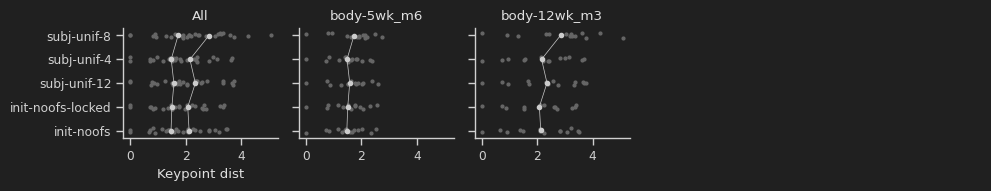

In [9]:
fig = viz.scans.withinbody_reconst_errs(project, ["subj-unif-4", "subj-unif-8", "subj-unif-12", 'init-noofs', 'init-noofs-locked'])
plotter.finalize(fig, None)

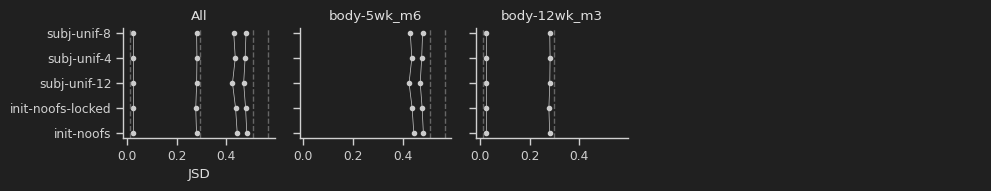

In [8]:
fig = viz.scans.jsds_to_reference(project, ["subj-unif-4", "subj-unif-8", "subj-unif-12", 'init-noofs', 'init-noofs-locked'])
plotter.finalize(fig, None)

##### Old wishart

Find the GMM alloctes a set of components almost uniquely to each animal.

Main difference between new and old code is the calibration: in particular the number of modes is much higher and the wishart variance has increased slightly. Test whether either of these forces GMM to use the same components

In [38]:
model_dir, cfg = create_model(project, 'wish-10',
    config = config.load_model_config(project.model_config('prior-scan_1')),
    config_overrides = {
    'pose.wish_var': 10.,
    'pose.wish_dof': 50.,
})
fit_data = methods.fit(
    project.model('wish-10'),
    log_every = 1,)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 1796 frames
INFO:root:Adjusting learning rate:8 -> 0.0011134307585247043
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 616775.625
INFO:root:Step 1 : loss = 607036.6875
INFO:root:Step 2 : loss = 602635.9375
INFO:root:Step 3 : loss = 600700.5
INFO:root:Step 4 : loss = 599762.75
INFO:root:Step 5 : loss = 598949.375
INFO:root:Step 6 : loss = 598068.5
INFO:root:Step 7 : loss = 597613.0625
INFO:root:Step 8 : loss = 597353.375
INFO:root:Step 9 : loss = 597132.1875
INFO:root:Step 10 : loss = 596983.875
INFO:root:Step 11 : loss = 596692.1875
INFO:root:Step 12 : loss = 596480.8125
INFO:root:Step 13 : loss = 596320.6875
INFO:root:Step 14 : loss = 596163.875
INFO:root:Step 15 : loss = 595862.0
INFO:root:Step 16 : loss = 595604.1875
INFO:root:Step 17 : loss = 595505.9375
INFO:root:Step 18 : loss = 595443.125
INFO:root:Step 19 : loss = 595395.5625
INFO:root:Step 20 : loss = 595353.6875
INFO

In [6]:
model_dir, cfg = create_model(project, 'morph-L3',
    config = config.load_model_config(project.model_config('prior-scan_1')),
    config_overrides = {
    'morph.n_dims': 3,
})
fit_data = methods.fit(
    project.model('morph-L3'),
    log_every = 1,)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 1796 frames
INFO:root:Adjusting learning rate:8 -> 0.0011134307585247043
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 622820.3125
INFO:root:Step 1 : loss = 611407.875
INFO:root:Step 2 : loss = 605812.5625
INFO:root:Step 3 : loss = 603012.1875
INFO:root:Step 4 : loss = 601841.625
INFO:root:Step 5 : loss = 600961.125
INFO:root:Step 6 : loss = 600408.75
INFO:root:Step 7 : loss = 600037.4375
INFO:root:Step 8 : loss = 599781.8125
INFO:root:Step 9 : loss = 599570.25
INFO:root:Step 10 : loss = 599286.1875
INFO:root:Step 11 : loss = 599080.5
INFO:root:Step 12 : loss = 598946.4375
INFO:root:Step 13 : loss = 598884.5
INFO:root:Step 14 : loss = 598767.875
INFO:root:Step 15 : loss = 598435.5
INFO:root:Step 16 : loss = 598186.375
INFO:root:Step 17 : loss = 598066.1875
INFO:root:Step 18 : loss = 597921.125
INFO:root:Step 19 : loss = 597801.4375
INFO:root:Step 20 : loss = 597666.6875
INFO:r

##### Subject uniformity

In [9]:
model_dir, cfg = create_model(project, 'subj-unif-4',
    config = config.load_model_config(project.model_config('prior-scan_1')),
    config_overrides = {
    'pose.subj_weight_uniformity': 1e4,
    'fit.em.n_steps': 400,
})
fit_data = methods.fit(
    project.model('subj-unif-4'),
    log_every = 1,)

INFO:root:Continuing from checkpoint at step 99.
INFO:root:Adjusting learning rate:8 -> 0.0011134307585247043
INFO:root:Loading LR schedule: const
INFO:root:Step 100 : loss = 593014.6875
INFO:root:Step 101 : loss = 593015.0
INFO:root:Step 102 : loss = 593010.75
INFO:root:Step 103 : loss = 593009.25
INFO:root:Step 104 : loss = 593009.0
INFO:root:Step 105 : loss = 593008.0
INFO:root:Step 106 : loss = 593006.0
INFO:root:Step 107 : loss = 593002.75
INFO:root:Step 108 : loss = 592996.75
INFO:root:Step 109 : loss = 592996.75
INFO:root:Step 110 : loss = 592992.25
INFO:root:Step 111 : loss = 592993.75
INFO:root:Step 112 : loss = 592990.75
INFO:root:Step 113 : loss = 592989.0
INFO:root:Step 114 : loss = 592987.4375
INFO:root:Step 115 : loss = 592990.1875
INFO:root:Step 116 : loss = 592987.75
INFO:root:Step 117 : loss = 592985.75
INFO:root:Step 118 : loss = 592979.375
INFO:root:Step 119 : loss = 592979.0625
INFO:root:Step 120 : loss = 592982.125
INFO:root:Step 121 : loss = 592977.375
INFO:root:S

##### without offset init

In [ ]:
model_dir, cfg = create_model(project, 'init-noofs-locked',
    config = config.load_model_config(project.model_config('prior-scan_1')),
    config_overrides = {
    'morph.init.offsets': False,
    'fit.em.n_steps': 400,
    'pose.init.uniform': True,
    'fit.em.update_blacklist': ["0/0"],
})
fit_data = methods.fit(
    project.model('init-noofs-locked'),
    log_every = 1,)

##### Looking at actual mice from above

What is the transform between these animals doing.

12wk_m3.0 [1502    7  851  878  359  544] (1796, 14, 3)
12wk_m3.1 [1006  944 1750  504  184  711] (1796, 14, 3)
5wk_m6.0 [  27  337 1691  565 1449  707] (1797, 14, 3)
5wk_m6.1 [ 205  546 1375 1728 1412  911] (1796, 14, 3)


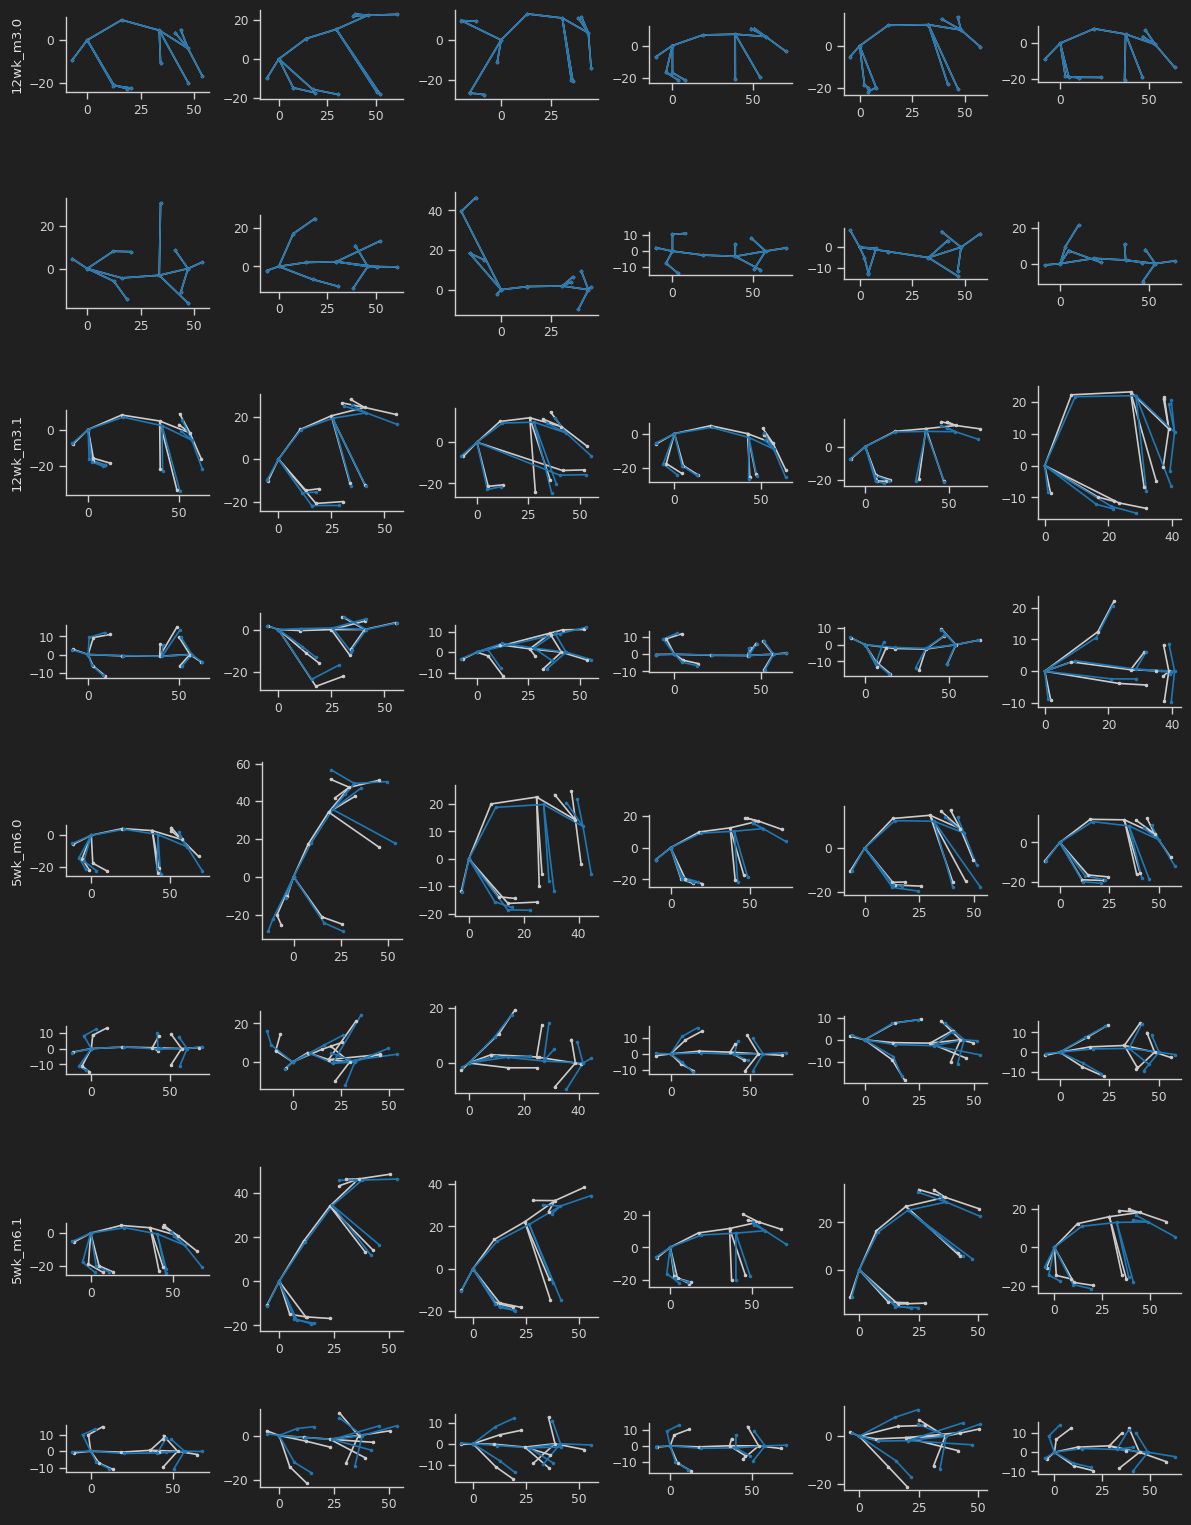

In [29]:
model_name = 'prior-scan_1'
cfg = config.load_model_config(project.model_config(model_name))
dataset, _body_inv, _inflate = scans._dataset_and_bodies_inv(project, model_name)
model = instantiation.get_model(cfg)
checkpoint = methods.load_fit(project.model(model_name))
arm = Armature.from_config(cfg['dataset'])

# transform all sessions to the global reference session's body


ref_body = dataset.sess_bodies[dataset.ref_session]
mapped_reduced = model_util.apply_bodies(
    model.morph,
    checkpoint["params"].morph,
    dataset,
    {s: ref_body for s in dataset.sessions},
)
aligned = _inflate(dataset)
mapped = _inflate(mapped_reduced)


fig, ax = plt.subplots(2 * dataset.n_sessions, 6, figsize = (2 * 6, 4 * dataset.n_sessions))

for i, s in enumerate(dataset.sessions):

    gallery_ixs = viz.util.select_frame_gallery(aligned.get_session(s), arm, return_ixs=True, as_list=True)
    print(s, gallery_ixs, aligned.get_session(s).shape)
    orig_poses = aligned.get_session(s)[gallery_ixs]
    mapped_poses = mapped.get_session(s)[gallery_ixs]

    for j, (orig_pose, mapped_pose) in enumerate(zip(orig_poses, mapped_poses)):
        a = ax[2 * i : 2 * (i + 1), j]
        viz.util.plot_mouse_views(a, orig_pose, arm, color = colors.neutral)
        viz.util.plot_mouse_views(a, mapped_pose, arm, color = colors.C[0])
    
    ax[2 * i, 0].set_ylabel(s)

# for a in ax.flatten():
#     viz.util.axes_off(a)

plotter.finalize(fig, None)



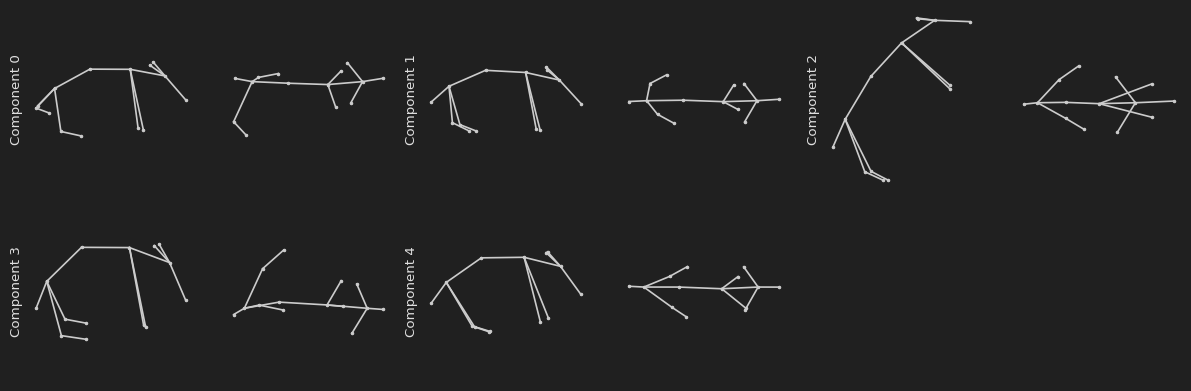

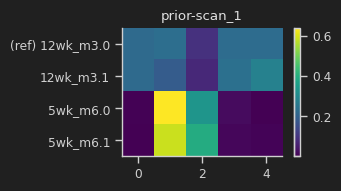

In [41]:
model_name = 'prior-scan_1'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
_dataset, _, _inflate = scans._dataset_and_bodies_inv(project, model_name)
params = ckpt["params"].pose

fig, ax, ax_grid = viz.util.flat_grid(params.n_components * 2, 6, (2, 2))
for i in range(params.n_components):
    pose = _inflate(params.means[i:i+1])[0]
    viz.util.plot_mouse_views(ax[i * 2 : (i + 1) * 2], pose, arm, color = colors.neutral)
    ax[i * 2].set_ylabel(f"Component {i}")

for a in ax:
    viz.util.axes_off(a)
plotter.finalize(fig, None, despine=False)

fig, ax = plt.subplots(figsize = (3.5, 2))
plt.imshow(ckpt["params"].pose.subj_weights)
ax.set_yticks(range(len(_dataset.sessions)))
ax.set_yticklabels([
    ("(ref) " if _dataset._session_names[i] == _dataset.ref_session else "") + _dataset._session_names[i]
    for i in range(len(_dataset.sessions))])
ax.set_title(model_name)
plt.colorbar()
plotter.finalize(fig, None)